In [1]:
import pandas as pd

In [2]:
df_Lkp_Areas = pd.read_csv('data/Lkp_Areas.csv')
df_Lkp_Areas.head(2)

,area_id,name_en,name_ar,municipality_number
0,451,Al Hebiah Fifth,الحبيه الخامسة,683
1,452,Al Hebiah Second,الحبيه الثانية,675


In [3]:
df_Lkp_Market_Types = pd.read_csv('data/Lkp_Market_Types.csv')
df_Lkp_Areas.head(2)

,area_id,name_en,name_ar,municipality_number
0,451,Al Hebiah Fifth,الحبيه الخامسة,683
1,452,Al Hebiah Second,الحبيه الثانية,675


In [4]:
df_Lkp_Transaction_Groups = pd.read_csv('data/Lkp_Transaction_Groups.csv')
df_Lkp_Areas.head(2)

,area_id,name_en,name_ar,municipality_number
0,451,Al Hebiah Fifth,الحبيه الخامسة,683
1,452,Al Hebiah Second,الحبيه الثانية,675


In [5]:
df_Lkp_Transaction_Procedures = pd.read_csv('data/Lkp_Transaction_Procedures.csv')
df_Lkp_Areas.head(2)

,area_id,name_en,name_ar,municipality_number
0,451,Al Hebiah Fifth,الحبيه الخامسة,683
1,452,Al Hebiah Second,الحبيه الثانية,675


In [6]:
df_Residential_Sale_Index =  pd.read_csv('data/Residential_Sale_Index.csv')
df_Lkp_Areas.head(2)

,area_id,name_en,name_ar,municipality_number
0,451,Al Hebiah Fifth,الحبيه الخامسة,683
1,452,Al Hebiah Second,الحبيه الثانية,675


In [8]:
df_Residential_Sale_Index =  pd.read_csv('data/Transactions.csv', encoding="utf-8", na_values="NA")
df_Lkp_Areas.head(2)

,area_id,name_en,name_ar,municipality_number
0,451,Al Hebiah Fifth,الحبيه الخامسة,683
1,452,Al Hebiah Second,الحبيه الثانية,675


In [9]:
len(df_Residential_Sale_Index)

1475500

In [10]:
len(df_Residential_Sale_Index.columns)

46

In [14]:
# Load Transactions dataset

transactions = pd.read_csv('data/Transactions.csv', encoding='utf-8', na_values='NA')
transactions.head()

,transaction_id,procedure_id,trans_group_id,trans_group_ar,trans_group_en,procedure_name_ar,procedure_name_en,instance_date,property_type_id,property_type_ar,...,rooms_en,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
0,3-9-2014-788,9,3,هبات,Gifts,هبه,Grant,06-11-2014,4,فيلا,...,NaN,0,3932.38,24789724.0,6304.00,NaN,NaN,2.0,1.0,0.0
1,2-13-1999-1955,13,2,رهون,Mortgages,تسجيل رهن,Mortgage Registration,23-11-1999,4,فيلا,...,NaN,0,1393.55,250000.0,179.40,NaN,NaN,1.0,1.0,0.0
2,2-13-2007-1862,13,2,رهون,Mortgages,تسجيل رهن,Mortgage Registration,26-09-2007,4,فيلا,...,NaN,0,1998.81,300000.0,150.09,NaN,NaN,1.0,1.0,0.0
3,1-11-2003-975,11,1,مبايعات,Sales,بيع,Sell,02-07-2003,4,فيلا,...,NaN,0,257.43,470000.0,1825.74,NaN,NaN,1.0,1.0,0.0
4,1-11-2016-170,11,1,مبايعات,Sales,بيع,Sell,05-01-2016,2,مبنى,...,NaN,0,818.38,13000000.0,15885.04,NaN,NaN,14.0,1.0,0.0


In [19]:
# === FULL PIPELINE: Generate ML-Ready Dataset for Off-Plan Profitability ===

import pandas as pd

# === Step 1: Load input data ===
transactions = pd.read_csv("./data/Transactions.csv", usecols=[
    "transaction_id", "procedure_id", "project_number", "project_name_en",
    "instance_date", "area_id", "actual_worth", "meter_sale_price"
], encoding='utf-8', on_bad_lines='skip')

procedures = pd.read_csv("./data/Lkp_Transaction_Procedures.csv", usecols=["procedure_id", "is_pre_registration"])
areas = pd.read_csv("./data/Lkp_Areas.csv", usecols=["area_id", "name_en"]).rename(columns={"name_en": "area_name_en"})

# === Step 2: Label off-plan transactions ===
transactions = transactions.merge(procedures, on="procedure_id", how="left")
transactions["is_off_plan"] = transactions["is_pre_registration"] == 1
transactions = transactions.merge(areas, on="area_id", how="left")
transactions["instance_date"] = pd.to_datetime(transactions["instance_date"], dayfirst=True, errors="coerce")
transactions["year"] = transactions["instance_date"].dt.year

# === Step 3: Filter valid project data ===
transactions = transactions.dropna(subset=["project_number"])

# === Step 4: Aggregate resale and off-plan prices ===
resale = transactions[transactions["is_off_plan"] == False].groupby("project_number").agg(
    resale_avg_meter_price=("meter_sale_price", "mean"),
    resale_avg_actual_worth=("actual_worth", "mean"),
    resale_count=("transaction_id", "count")
)

offplan = transactions[transactions["is_off_plan"] == True].groupby("project_number").agg(
    offplan_avg_meter_price=("meter_sale_price", "mean"),
    offplan_avg_actual_worth=("actual_worth", "mean"),
    offplan_earliest_year=("year", "min"),
    offplan_count=("transaction_id", "count")
)

# === Step 5: Merge and calculate return ===
project_comparison = offplan.join(resale, how="inner")
project_comparison["price_gain_%"] = (
    (project_comparison["resale_avg_meter_price"] - project_comparison["offplan_avg_meter_price"])
    / project_comparison["offplan_avg_meter_price"]
) * 100

# === Step 6: Create ML-ready table ===
ml_ready_df = project_comparison.reset_index()
ml_ready_df = ml_ready_df.dropna()

ml_ready_df = ml_ready_df[ml_ready_df["offplan_avg_meter_price"] > 0]
ml_ready_df["profitable"] = (ml_ready_df["price_gain_%"] > 0).astype(int)

# === Step 7: Export ===
ml_ready_df.to_csv("./data/offplan_project_comparison_ml_ready.csv", index=False)
print("✅ Saved as offplan_project_comparison_ml_ready.csv")


✅ Saved as offplan_project_comparison_ml_ready.csv


In [20]:

# === ML Analysis: Predicting Profitable Off-Plan Projects ===

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset created earlier
ml_df = pd.read_csv('./data/offplan_project_comparison_ml_ready.csv')

# Define features and target
features = [
    "offplan_avg_meter_price",
    "offplan_avg_actual_worth",
    "offplan_earliest_year",
    "offplan_count",
    "resale_count"
]
X = ml_df[features]
y = ml_df["profitable"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       234
           1       0.72      0.64      0.68       129

    accuracy                           0.79       363
   macro avg       0.77      0.75      0.76       363
weighted avg       0.78      0.79      0.78       363



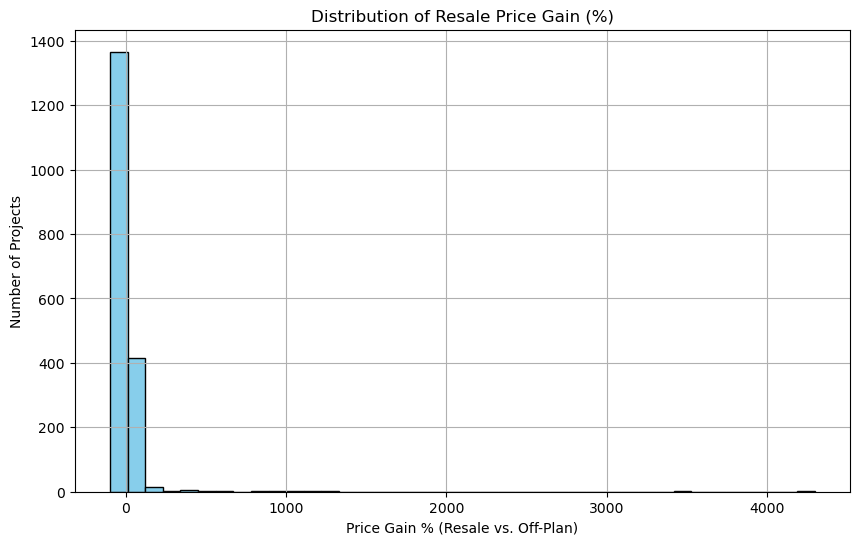

Average gain from off-plan to resale: -6.72 %
Median gain: -12.31 %

Top 10 Most Profitable Projects:


,offplan_avg_meter_price,offplan_avg_actual_worth,offplan_earliest_year,offplan_count,resale_avg_meter_price,resale_avg_actual_worth,resale_count,price_gain_%
project_number,,,,,,,,
14.0,9717.103500,8.390025e+05,2016.0,40,4.273570e+05,3.942700e+07,4,4297.987374
1382.0,44037.062889,3.518134e+06,2015.0,90,1.587343e+06,1.261928e+08,34,3504.562527
3257.0,108255.480000,7.856100e+06,2025.0,1,1.433450e+06,5.326873e+09,6,1224.136432
2503.0,16104.382184,5.054252e+06,2023.0,174,2.029711e+05,1.215222e+08,368,1160.347173
1785.0,11654.902000,1.057312e+06,2018.0,30,1.292393e+05,1.561563e+07,3,1008.883798
2680.0,53926.780441,1.968284e+07,2022.0,68,5.665951e+05,5.691000e+08,5,950.674895
2333.0,19458.095377,2.391638e+06,2022.0,106,1.744768e+05,2.737279e+07,195,796.679619
255.0,10886.466239,9.505201e+05,2009.0,234,9.718338e+04,1.089714e+07,452,792.699041
1524.0,12115.632157,1.836658e+06,2015.0,357,8.508196e+04,1.084057e+07,416,602.249464



Bottom 10 Least Profitable Projects:


,offplan_avg_meter_price,offplan_avg_actual_worth,offplan_earliest_year,offplan_count,resale_avg_meter_price,resale_avg_actual_worth,resale_count,price_gain_%
project_number,,,,,,,,
3585.0,2.784782e+04,1.593186e+06,2025.0,32,0.020000,1.150000e+02,1,-99.999928
1223.0,7.223354e+06,6.746725e+05,2009.0,50,6857.409524,6.365944e+05,147,-99.905066
1194.0,6.451335e+06,6.374528e+05,2009.0,301,6872.881370,6.409913e+05,292,-99.893466
1201.0,5.926122e+06,6.356219e+05,2009.0,30,6901.294521,7.711412e+05,261,-99.883545
342.0,6.881540e+03,5.875540e+05,2010.0,7,10.760000,8.252040e+05,1,-99.843640
3474.0,2.075434e+04,7.314198e+05,2025.0,226,272.850000,2.025142e+07,1,-98.685335
2830.0,1.881302e+04,8.687242e+05,2024.0,263,247.350000,5.643771e+06,1,-98.685219
2829.0,1.832778e+04,9.453584e+05,2023.0,201,247.350000,5.665285e+06,1,-98.650409
2956.0,1.845564e+04,7.914005e+05,2024.0,462,251.660000,1.292670e+07,1,-98.636406


In [21]:
# === ANALYTICS: Explore Off-Plan Resale Gains ===

import matplotlib.pyplot as plt

# Make sure project_comparison is defined
try:
    _ = project_comparison
except NameError:
    print("Please make sure you've created 'project_comparison' DataFrame from earlier steps.")
else:
    # Histogram of resale price gains
    plt.figure(figsize=(10, 6))
    project_comparison["price_gain_%"].hist(bins=40, color="skyblue", edgecolor="black")
    plt.title("Distribution of Resale Price Gain (%)")
    plt.xlabel("Price Gain % (Resale vs. Off-Plan)")
    plt.ylabel("Number of Projects")
    plt.grid(True)
    plt.show()

    # Summary statistics
    print("Average gain from off-plan to resale:", round(project_comparison["price_gain_%"].mean(), 2), "%")
    print("Median gain:", round(project_comparison["price_gain_%"].median(), 2), "%")

    # Top 10 most profitable projects
    print("\nTop 10 Most Profitable Projects:")
    display(project_comparison.sort_values("price_gain_%", ascending=False).head(10))

    # Bottom 10 least profitable projects
    print("\nBottom 10 Least Profitable Projects:")
    display(project_comparison.sort_values("price_gain_%").head(10))


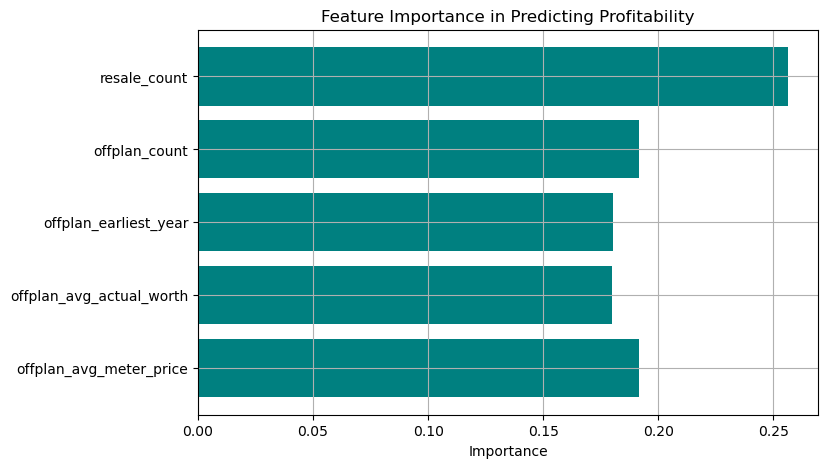

In [23]:
# === Feature Importance (Random Forest)
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='teal')
plt.title("Feature Importance in Predicting Profitability")
plt.xlabel("Importance")
plt.grid(True)
plt.show()


In [ ]:
# === FULL PIPELINE: Generate ML-Ready Dataset for Off-Plan Profitability ===

import pandas as pd

# === Step 1: Load input data ===
transactions = pd.read_csv("data/Transactions.csv", usecols=[
    "transaction_id", "procedure_id", "project_number", "project_name_en",
    "instance_date", "area_id", "actual_worth", "meter_sale_price"
], encoding='utf-8', on_bad_lines='skip')

procedures = pd.read_csv("data/Lkp_Transaction_Procedures.csv", usecols=["procedure_id", "is_pre_registration"])
areas = pd.read_csv("data/Lkp_Areas.csv", usecols=["area_id", "name_en"]).rename(columns={"name_en": "area_name_en"})

# === Step 2: Merge and prepare fields ===
transactions = transactions.merge(procedures, on="procedure_id", how="left")
transactions["is_off_plan"] = transactions["is_pre_registration"] == 1
transactions = transactions.merge(areas, on="area_id", how="left")
transactions["instance_date"] = pd.to_datetime(transactions["instance_date"], dayfirst=True, errors="coerce")
transactions["year"] = transactions["instance_date"].dt.year

# === Step 3: Filter valid project data ===
transactions = transactions.dropna(subset=["project_number"])

# === Step 4: Aggregate resale and off-plan prices ===
resale = transactions[transactions["is_off_plan"] == False].groupby("project_number").agg(
    resale_avg_meter_price=("meter_sale_price", "mean"),
    resale_avg_actual_worth=("actual_worth", "mean"),
    resale_count=("transaction_id", "count")
)

offplan = transactions[transactions["is_off_plan"] == True].groupby("project_number").agg(
    offplan_avg_meter_price=("meter_sale_price", "mean"),
    offplan_avg_actual_worth=("actual_worth", "mean"),
    offplan_earliest_year=("year", "min"),
    offplan_count=("transaction_id", "count")
)

# === Step 5: Merge and calculate return ===
project_comparison = offplan.join(resale, how="inner")
project_comparison["price_gain_%"] = (
    (project_comparison["resale_avg_meter_price"] - project_comparison["offplan_avg_meter_price"])
    / project_comparison["offplan_avg_meter_price"]
) * 100

# === Step 6: Clean and add classification label ===
ml_ready_df = project_comparison.reset_index()
ml_ready_df = ml_ready_df.dropna()
ml_ready_df = ml_ready_df[ml_ready_df["offplan_avg_meter_price"] > 0]
ml_ready_df["profitable"] = (ml_ready_df["price_gain_%"] > 0).astype(int)

# === Step 7: Save for ML use ===
ml_ready_df.to_csv("data/offplan_project_comparison_ml_ready.csv", index=False)
print("✅ File saved: offplan_project_comparison_ml_ready.csv")


✅ File saved: offplan_project_comparison_ml_ready.csv
